In [1]:
import numpy as np

import theano
import theano.tensor as T
import lasagne

from tqdm import tqdm

import time
from IPython import display

import matplotlib.pyplot as plt

In [2]:
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [3]:
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

class GaussianSampleLayer(lasagne.layers.MergeLayer):
    def __init__(self, mu, logsigma, **kwargs):
        self.rng = RandomStreams(lasagne.random.get_rng().randint(1,2147462579))
        super(GaussianSampleLayer, self).__init__([mu, logsigma], **kwargs)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, logsigma = inputs
        shape=(self.input_shapes[0][0] or inputs[0].shape[0],
                self.input_shapes[0][1] or inputs[0].shape[1])
        if deterministic:
            return mu
        return mu + T.exp(logsigma) * self.rng.normal(shape)

In [4]:
def KL_divergence(mu, log_sigma):
    KLD = 0.5 * T.sum(1 + 2*log_sigma - T.sqr(mu) - T.exp(2*log_sigma))
    return KLD

def log_likelihood(tgt, mu, ls):
    return T.sum(-(np.float32(0.5 * np.log(2 * np.pi)) + ls)
            - 0.5 * T.sqr(tgt - mu) / T.exp(2 * ls) )

In [5]:
X = np.load("../data/npy/ES3_R1.npy")
X_ans_split = np.load("../data/npy/ES3_R1_ans.npy.npz")

In [6]:
X_ans = np.concatenate(X_ans_split.items()[0][1])

# VAE 1

internal dim 10
hid 50

In [8]:
def get_one_layer_VAE(input_X, lr, w = 5, HU_encoder = 50, HU_decoder = 50, dimZ = 2, input_shape = [None,32*4]):
    vl_input = lasagne.layers.InputLayer(input_shape)
    vl_enc_hid = lasagne.layers.DenseLayer(vl_input, num_units=HU_encoder, nonlinearity = lasagne.nonlinearities.elu)
    vl_enc_mu = lasagne.layers.DenseLayer(vl_enc_hid, dimZ, nonlinearity = None)
    vl_enc_logsigma = lasagne.layers.DenseLayer(vl_enc_hid, num_units=dimZ, nonlinearity = None)
    vl_z = GaussianSampleLayer(vl_enc_mu, vl_enc_logsigma)
    vl_dec_hid = lasagne.layers.DenseLayer(vl_z, num_units=HU_decoder, nonlinearity = lasagne.nonlinearities.elu)
    vl_dec_mu = lasagne.layers.DenseLayer(vl_dec_hid, num_units=input_shape[1],
                                          nonlinearity = lasagne.nonlinearities.sigmoid)
    relu_shift = 2
    vl_dec_logsigma = lasagne.layers.DenseLayer(vl_dec_hid, num_units=input_shape[1],
                        nonlinearity = lambda a: T.nnet.relu(a+relu_shift)-relu_shift)
    vl_output = GaussianSampleLayer(vl_dec_mu, vl_dec_logsigma)
    
    print("Theano started")
    # create prediction variable
    v_prediction = lasagne.layers.get_output(vl_output, inputs = input_X, deterministic=True)
    # create loss function
    mu_z = lasagne.layers.get_output(vl_enc_mu, inputs= input_X)
    logsigma_z = lasagne.layers.get_output(vl_enc_logsigma, inputs= input_X)
    mu_x = lasagne.layers.get_output(vl_dec_mu, inputs= input_X)
    logsigma_x = lasagne.layers.get_output(vl_dec_logsigma,inputs= input_X)
    v_loss = -1*(w* KL_divergence(mu_z,logsigma_z) + log_likelihood(input_X, mu_x, logsigma_x))


    # create parameter update expressions
    v_params = lasagne.layers.get_all_params(vl_output, trainable = True)
    v_updates = lasagne.updates.adam(v_loss, v_params, learning_rate=lr)

    # compile training and testing functions
    v_train_fn = theano.function([input_X], v_loss, updates = v_updates)
    v_test_fn = theano.function([input_X], v_prediction)
    v_test_loss_fn = theano.function([input_X], v_loss)
    v_logloss_fn = theano.function([input_X], log_likelihood(input_X, mu_x, logsigma_x))

    internal = theano.function([input_X], mu_z)
    
    return v_train_fn, v_test_fn, internal

## W = 1

In [16]:
input_X = T.matrix("X")
input_shape = [None,32*4]

lr = theano.shared(0.001)

train_fn_1, test_fn_1, internal_1 = get_one_layer_VAE(input_X, lr, 1)

Theano started


In [17]:
epochs = 30
v_losses_train = []
v_logloss = []
#v_losses_valid = []
#val_batches = 500
batch_size = 100

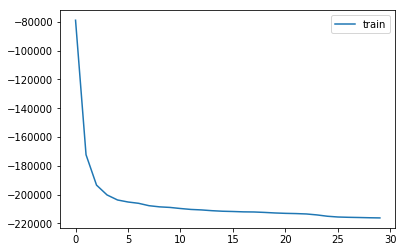

In [18]:
for epoch in range(epochs):
    ls_tr = 0.
    logloss_tr = 0.
    for batch in iterate_minibatches(X, batch_size):
        ls_tr += train_fn_1(batch)
        
    v_losses_train.append(ls_tr/ batch_size)
    #for batch in iterate_minibatches(X_val, val_batches):
    #    ls_val += v_test_loss_fn(batch)
    #v_losses_valid.append(ls_val/ val_batches)
    
    if epoch%2==1:
        display.clear_output(wait=True)
        plt.plot(v_losses_train, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()

In [19]:
Z = internal_1(X)
Z_ans = internal_1(X_ans)

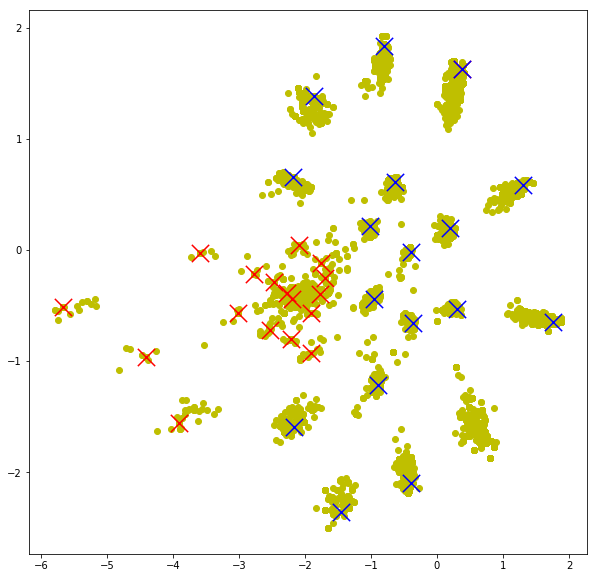

In [20]:
fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)
ax.scatter(Z[:, 0], Z[:,1], c='y')
ax.scatter(Z_ans[:18, 0]  , Z_ans[:18,1], c='r', marker= 'x', s = 300)
ax.scatter(Z_ans[18:, 0]  , Z_ans[18:,1], c='b' , marker= 'x', s = 300)
plt.show()

## W = 10

In [9]:
input_X = T.matrix("X")
input_shape = [None,32*4]

lr = theano.shared(0.001)

train_fn_3, test_fn_3, internal_3 = get_one_layer_VAE(input_X, lr, 10)

Theano started


In [10]:
epochs = 30
v_losses_train = []
v_logloss = []
#v_losses_valid = []
#val_batches = 500
batch_size = 100

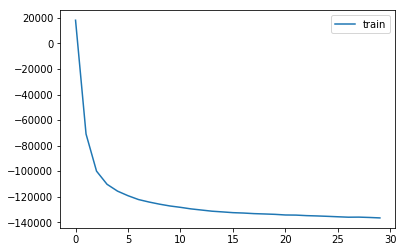

In [11]:
for epoch in range(epochs):
    ls_tr = 0.
    logloss_tr = 0.
    for batch in iterate_minibatches(X, batch_size):
        ls_tr += train_fn_3(batch)
        
    v_losses_train.append(ls_tr/ batch_size)
    #for batch in iterate_minibatches(X_val, val_batches):
    #    ls_val += v_test_loss_fn(batch)
    #v_losses_valid.append(ls_val/ val_batches)
    
    if epoch%2==1:
        display.clear_output(wait=True)
        plt.plot(v_losses_train, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()

In [13]:
Z_3 = internal_3(X)
Z_ans_3 = internal_3(X_ans)

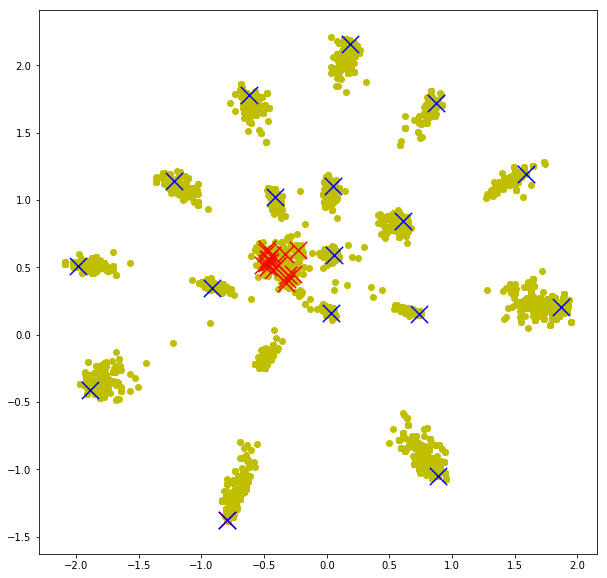

In [14]:
fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)
ax.scatter(Z_3[:, 0], Z_3[:,1], c='y')
ax.scatter(Z_ans_3[:18, 0]  , Z_ans_3[:18,1], c='r', marker= 'x', s = 300)
ax.scatter(Z_ans_3[18:, 0]  , Z_ans_3[18:,1], c='b' , marker= 'x', s = 300)
plt.show()

## W = 30

In [16]:
input_X = T.matrix("X")
input_shape = [None,32*4]

lr = theano.shared(0.001)

train_fn_2, test_fn_2, internal_2 = get_one_layer_VAE(input_X, lr, 30)

Theano started


In [18]:
epochs = 50
v_losses_train = []
v_logloss = []
#v_losses_valid = []
#val_batches = 500
batch_size = 100

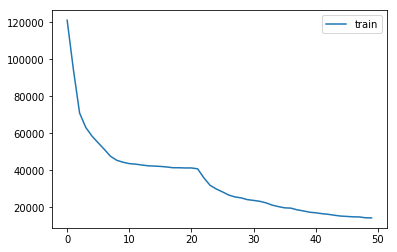

In [19]:
for epoch in range(epochs):
    ls_tr = 0.
    logloss_tr = 0.
    for batch in iterate_minibatches(X, batch_size):
        ls_tr += train_fn_2(batch)
        
    v_losses_train.append(ls_tr/ batch_size)
    #for batch in iterate_minibatches(X_val, val_batches):
    #    ls_val += v_test_loss_fn(batch)
    #v_losses_valid.append(ls_val/ val_batches)
    
    if epoch%2==1:
        display.clear_output(wait=True)
        plt.plot(v_losses_train, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()

In [31]:
Z_2 = internal_2(X)
Z_ans_2 = internal_2(X_ans)

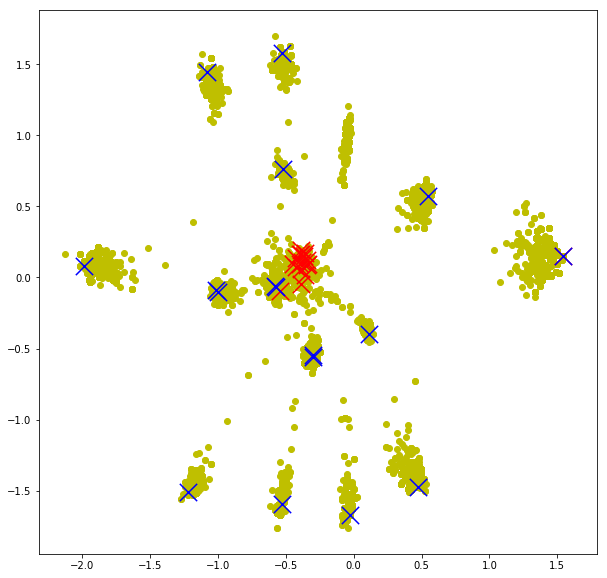

In [32]:
fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)
ax.scatter(Z_2[:, 0], Z_2[:,1], c='y')
ax.scatter(Z_ans_2[:18, 0]  , Z_ans_2[:18,1], c='r', marker= 'x', s = 300)
ax.scatter(Z_ans_2[18:, 0]  , Z_ans_2[18:,1], c='b' , marker= 'x', s = 300)
plt.show()

## W = 0

In [34]:
input_X = T.matrix("X")
input_shape = [None,32*4]

lr = theano.shared(0.001)

train_fn_4, test_fn_4, internal_4 = get_one_layer_VAE(input_X, lr, 0)

Theano started


In [35]:
epochs = 30
v_losses_train = []
v_logloss = []
#v_losses_valid = []
#val_batches = 500
batch_size = 100

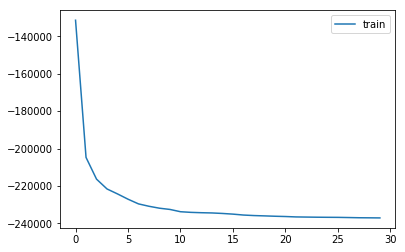

In [36]:
for epoch in range(epochs):
    ls_tr = 0.
    logloss_tr = 0.
    for batch in iterate_minibatches(X, batch_size):
        ls_tr += train_fn_4(batch)
        
    v_losses_train.append(ls_tr/ batch_size)
    #for batch in iterate_minibatches(X_val, val_batches):
    #    ls_val += v_test_loss_fn(batch)
    #v_losses_valid.append(ls_val/ val_batches)
    
    if epoch%2==1:
        display.clear_output(wait=True)
        plt.plot(v_losses_train, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()

In [37]:
Z_4 = internal_4(X)
Z_ans_4 = internal_4(X_ans)

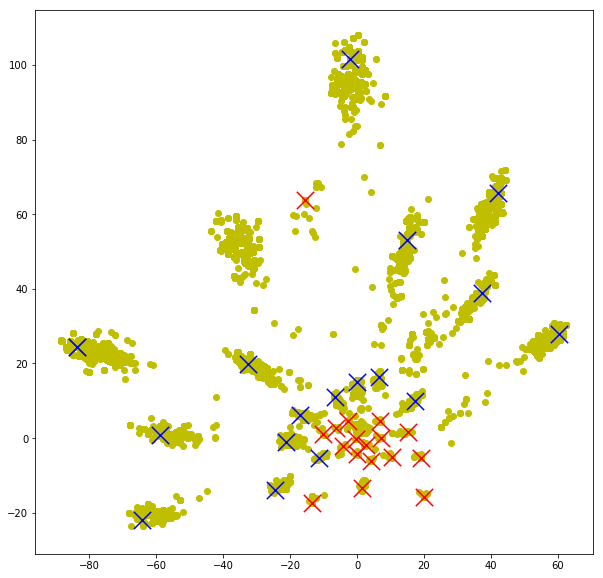

In [39]:
fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)
ax.scatter(Z_4[:, 0], Z_4[:,1], c='y')
ax.scatter(Z_ans_4[:18, 0]  , Z_ans_4[:18,1], c='r', marker= 'x', s = 300)
ax.scatter(Z_ans_4[18:, 0]  , Z_ans_4[18:,1], c='b' , marker= 'x', s = 300)
plt.show()

In [40]:
Z_4_u, counts_4 = np.unique(Z_4, axis =0,return_counts=True)

In [84]:
mask = counts_4 > 15

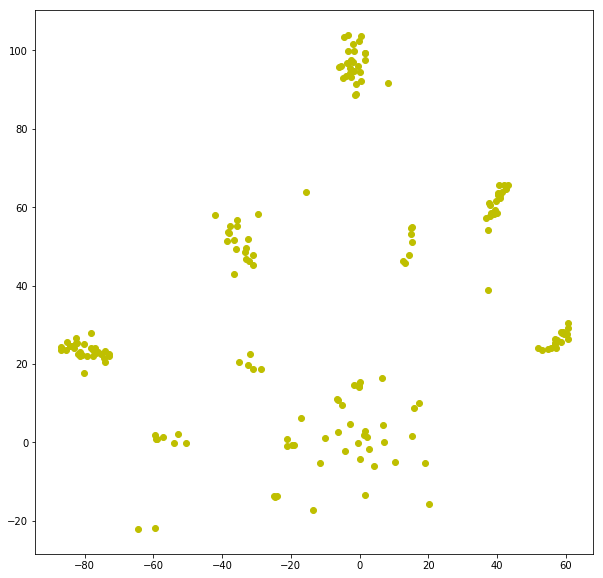

In [86]:
fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)

#ax.scatter(Z_ans_4[:18, 0]  , Z_ans_4[:18,1], c='r', marker= 'x', s = 300)
#ax.scatter(Z_ans_4[18:, 0]  , Z_ans_4[18:,1], c='b' , marker= 'x', s = 300)
ax.scatter(Z_4_u[:, 0][mask], Z_4_u[:,1][mask], c='y')
plt.show()

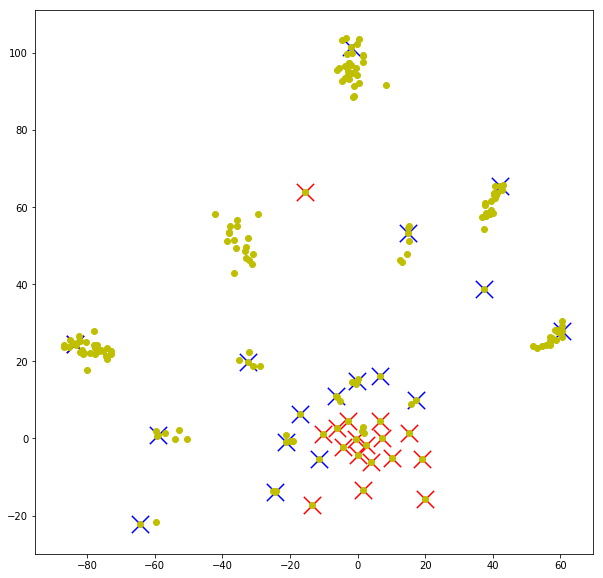

In [85]:
fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)

ax.scatter(Z_ans_4[:18, 0]  , Z_ans_4[:18,1], c='r', marker= 'x', s = 300)
ax.scatter(Z_ans_4[18:, 0]  , Z_ans_4[18:,1], c='b' , marker= 'x', s = 300)
ax.scatter(Z_4_u[:, 0][mask], Z_4_u[:,1][mask], c='y')
plt.show()

# VAE 2

internal dim 10
hid 50

In [87]:
input_X = T.matrix("X")
input_shape = [None,32*4]

lr = theano.shared(0.001)

train_fn_5, test_fn_5, internal_5 = get_one_layer_VAE(input_X, lr, 1, dimZ=10)

Theano started


In [88]:
epochs = 30
v_losses_train = []
v_logloss = []
#v_losses_valid = []
#val_batches = 500
batch_size = 100

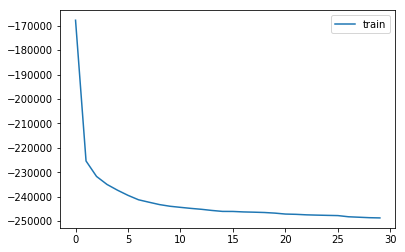

In [89]:
for epoch in range(epochs):
    ls_tr = 0.
    logloss_tr = 0.
    for batch in iterate_minibatches(X, batch_size):
        ls_tr += train_fn_5(batch)
        
    v_losses_train.append(ls_tr/ batch_size)
    #for batch in iterate_minibatches(X_val, val_batches):
    #    ls_val += v_test_loss_fn(batch)
    #v_losses_valid.append(ls_val/ val_batches)
    
    if epoch%2==1:
        display.clear_output(wait=True)
        plt.plot(v_losses_train, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()

In [90]:
Z_5 = internal_5(X)
Z_ans_5 = internal_5(X_ans)

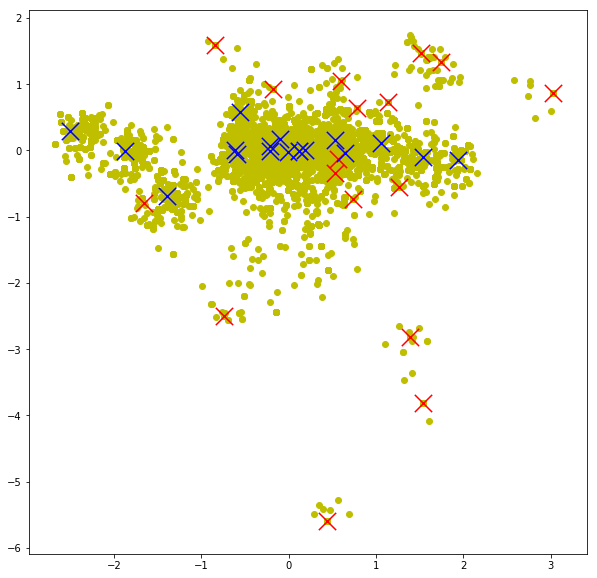

In [91]:
fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)
ax.scatter(Z_5[:, 0], Z_5[:,1], c='y')
ax.scatter(Z_ans_5[:18, 0]  , Z_ans_5[:18,1], c='r', marker= 'x', s = 300)
ax.scatter(Z_ans_5[18:, 0]  , Z_ans_5[18:,1], c='b' , marker= 'x', s = 300)
plt.show()

In [92]:
from sklearn.manifold import TSNE

tsne = TSNE(2, verbose=1)

In [93]:
def tsne_with_ans(tsne, data, ans):
    print(np.concatenate((data, ans)).shape)
    tsne_data = tsne.fit_transform(np.concatenate((data, ans)))
    return tsne_data[:data.shape[0]], tsne_data[-ans.shape[0]:]

In [94]:
T_5, T_ans_5 = tsne_with_ans(tsne, Z_5[::50], Z_ans_5)

(4001, 10)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4001 samples in 0.005s...
[t-SNE] Computed neighbors for 4001 samples in 0.158s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4001
[t-SNE] Computed conditional probabilities for sample 2000 / 4001
[t-SNE] Computed conditional probabilities for sample 3000 / 4001
[t-SNE] Computed conditional probabilities for sample 4000 / 4001
[t-SNE] Computed conditional probabilities for sample 4001 / 4001
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.446880
[t-SNE] Error after 1000 iterations: 0.343441


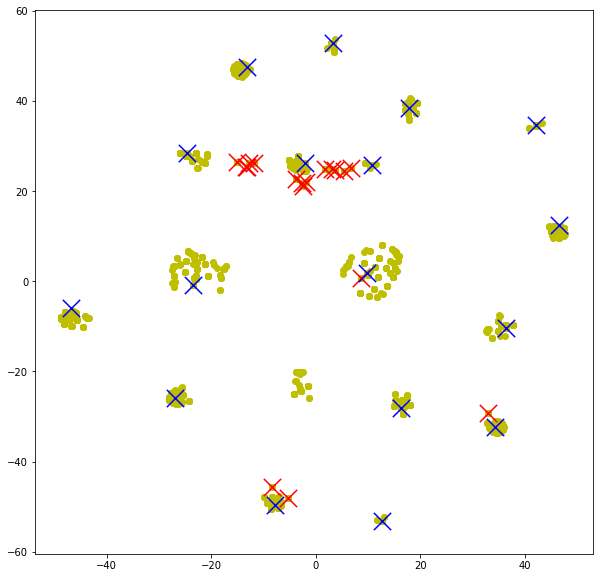

In [97]:

fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)
ax.scatter(T_5[:, 0], T_5[:,1], c='y')
ax.scatter(T_ans_5[:18, 0]  , T_ans_5[:18,1], c='r', marker= 'x', s = 300)
ax.scatter(T_ans_5[18:, 0]  , T_ans_5[18:,1], c='b' , marker= 'x', s = 300)
plt.show()

# CVAE

In [26]:
input_X = T.matrix("X")
input_shape = [None,32*4]

lr = theano.shared(0.001)

In [27]:
dimZ = 2
#HU_encoder = 20
#HU_decoder = 20

In [28]:
vl_input = lasagne.layers.InputLayer(input_shape)

vl_reshape_there = lasagne.layers.ReshapeLayer(vl_input, (-1, 4, 32))

vl_conv_1 = lasagne.layers.Conv1DLayer(vl_reshape_there, num_filters=8, filter_size=5, stride = 1, pad = 0)
vl_conv_2 = lasagne.layers.Conv1DLayer(vl_conv_1, 16, 5, stride = 3)

vl_reshape_back = lasagne.layers.ReshapeLayer(vl_conv_2, (-1, 8 * 16))

In [29]:
vl_enc_mu = lasagne.layers.DenseLayer(vl_reshape_back, dimZ, nonlinearity = None)
vl_enc_logsigma = lasagne.layers.DenseLayer(vl_reshape_back, num_units=dimZ, nonlinearity = None)

vl_z = GaussianSampleLayer(vl_enc_mu, vl_enc_logsigma)

In [30]:
vl_dec_hid = lasagne.layers.DenseLayer(vl_z, num_units= 8 * 16, nonlinearity = lasagne.nonlinearities.elu)
vl_dec_hid_rs = lasagne.layers.ReshapeLayer(vl_dec_hid, (-1, 16, 8))

In [31]:
upscale = lasagne.layers.Upscale1DLayer(vl_dec_hid_rs, 3)

vl_upconv_1 = lasagne.layers.Conv1DLayer(upscale, 8, 5, stride=1, pad = 4)

vl_upconv_2 = lasagne.layers.Conv1DLayer(vl_conv_1, 4, 5, stride=1, pad = 4)

In [32]:
vl_reshape_back = lasagne.layers.ReshapeLayer(vl_upconv_2, (-1, 32*4))

vl_dec_mu = lasagne.layers.DenseLayer(vl_reshape_back, num_units=input_shape[1],
                                      nonlinearity = lasagne.nonlinearities.sigmoid)
relu_shift = 2
vl_dec_logsigma = lasagne.layers.DenseLayer(vl_reshape_back, num_units=input_shape[1],
                    nonlinearity = lambda a: T.nnet.relu(a+relu_shift)-relu_shift)
vl_output = GaussianSampleLayer(vl_dec_mu, vl_dec_logsigma)

In [33]:
lasagne.layers.get_all_layers(vl_output)

lasagne.layers.get_output_shape(vl_output, (-1, 128))

(-1, 128)

In [34]:
# create prediction variable
v_prediction = lasagne.layers.get_output(vl_output, inputs = input_X, deterministic=True)
# create loss function
mu_z = lasagne.layers.get_output(vl_enc_mu, inputs= input_X)
logsigma_z = lasagne.layers.get_output(vl_enc_logsigma, inputs= input_X)
mu_x = lasagne.layers.get_output(vl_dec_mu, inputs= input_X)
logsigma_x = lasagne.layers.get_output(vl_dec_logsigma,inputs= input_X)
v_loss = -1*(0.1 * KL_divergence(mu_z,logsigma_z) + log_likelihood(input_X, mu_x, logsigma_x))


# create parameter update expressions
v_params = lasagne.layers.get_all_params(vl_output, trainable = True)
v_updates = lasagne.updates.adam(v_loss, v_params, learning_rate=0.001)

# compile training and testing functions
v_train_fn = theano.function([input_X], v_loss, updates = v_updates)
v_test_fn = theano.function([input_X], v_prediction)
v_test_loss_fn = theano.function([input_X], v_loss)

In [35]:
epochs = 40
v_losses_train = []
v_logloss = []
#v_losses_valid = []
#val_batches = 500
batch_size = 100

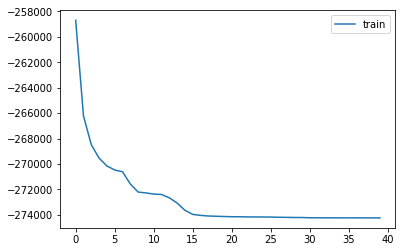

In [41]:
for epoch in range(epochs):
    ls_tr = 0.
    logloss_tr = 0.
    for batch in iterate_minibatches(X, batch_size):
        ls_tr += v_train_fn(batch)
        
    v_losses_train.append(ls_tr/ batch_size)
    v_logloss.append(logloss_tr / batch_size)
    #for batch in iterate_minibatches(X_val, val_batches):
    #    ls_val += v_test_loss_fn(batch)
    #v_losses_valid.append(ls_val/ val_batches)
    
    if epoch%2==1:
        display.clear_output(wait=True)
        plt.plot(v_losses_train, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()

In [42]:
internal = theano.function([input_X], mu_z)

Z = internal(X)
Z_ans = internal(X_ans)

In [47]:
max(abs(X[100] - v_test_fn(X[100:101])[0]))

0.00019957735937920062

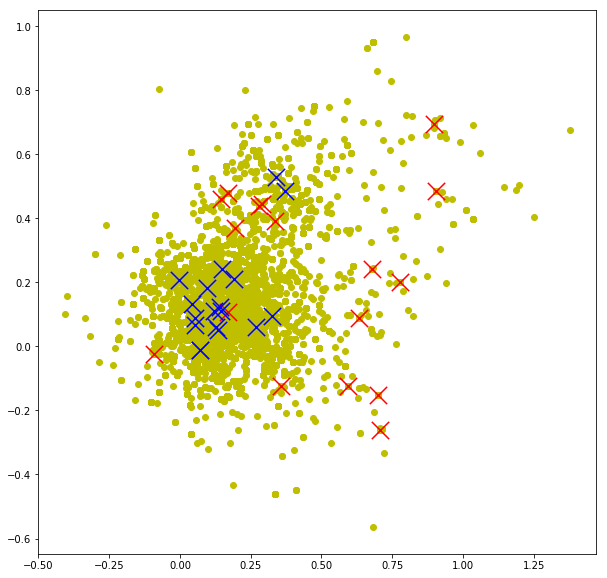

In [44]:
#15 iter
fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)
ax.scatter(Z[:, 0], Z[:,1], c='y')
ax.scatter(Z_ans[:18, 0]  , Z_ans[:18,1], c='r', marker= 'x', s = 300)
ax.scatter(Z_ans[18:, 0]  , Z_ans[18:,1], c='b' , marker= 'x', s = 300)
plt.show()

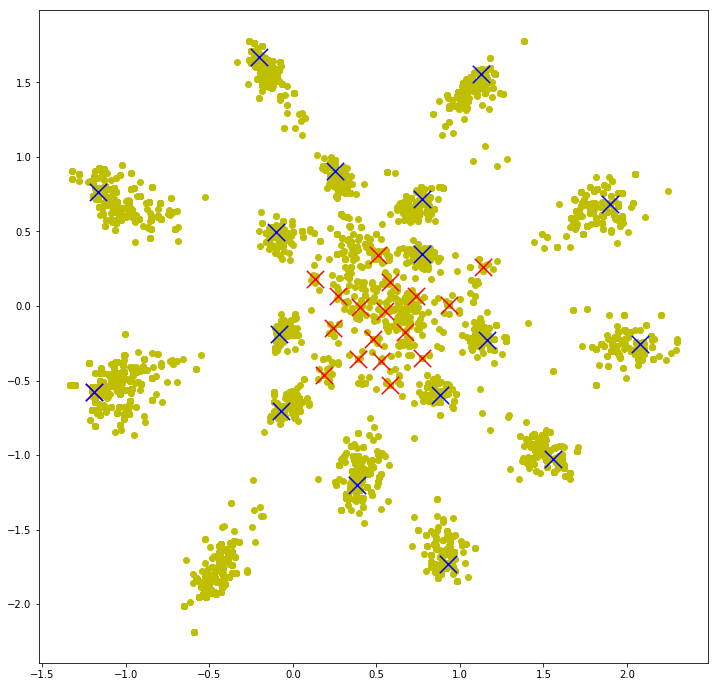

In [339]:
#30 iter
fig, ax =  plt.subplots()
fig.set_size_inches(12, 12)
ax.scatter(Z[:, 0], Z[:,1], c='y')
ax.scatter(Z_ans[:18, 0]  , Z_ans[:18,1], c='r', marker= 'x', s = 300)
ax.scatter(Z_ans[18:, 0]  , Z_ans[18:,1], c='b' , marker= 'x', s = 300)
plt.show()

# DET VAE

In [214]:
input_X = T.matrix("X")
input_shape = [None,32*4]

In [216]:
HU_encoder = 50
HU_decoder = 50
dimZ = 2

In [239]:
vl_input = lasagne.layers.InputLayer(input_shape)
vl_enc_hid = lasagne.layers.DenseLayer(vl_input, num_units=HU_encoder, nonlinearity = lasagne.nonlinearities.elu)
vl_enc_mu = lasagne.layers.DenseLayer(vl_enc_hid, dimZ, nonlinearity = None)
vl_enc_logsigma = lasagne.layers.DenseLayer(vl_enc_hid, num_units=dimZ, nonlinearity = None)
vl_z = GaussianSampleLayer(vl_enc_mu, vl_enc_logsigma)
vl_dec_hid = lasagne.layers.DenseLayer(vl_z, num_units=HU_decoder, nonlinearity = lasagne.nonlinearities.elu)
vl_output = lasagne.layers.DenseLayer(vl_dec_hid, num_units=input_shape[1],
                                      nonlinearity = lasagne.nonlinearities.sigmoid)
#relu_shift = 2
#vl_dec_logsigma = lasagne.layers.DenseLayer(vl_dec_hid, num_units=input_shape[1],
#                    nonlinearity = lambda a: T.nnet.relu(a+relu_shift)-relu_shift)
#vl_output = GaussianSampleLayer(vl_dec_mu, vl_dec_logsigma)

In [240]:
# create prediction variable
v_prediction = lasagne.layers.get_output(vl_output, inputs = input_X, deterministic=True)
# create loss function
out = lasagne.layers.get_output(vl_output, inputs = input_X)
#logsigma_z = lasagne.layers.get_output(vl_enc_logsigma, inputs= input_X)
#mu_x = lasagne.layers.get_output(vl_dec_mu, inputs= input_X)
#logsigma_x = lasagne.layers.get_output(vl_dec_logsigma,inputs= input_X)
v_loss = -1*(KL_divergence(mu_z,logsigma_z) + 100* lasagne.objectives.squared_error(input_X, out).mean()) 

#log_likelihood(input_X, mu_x, logsigma_x))

# create parameter update expressions
v_params = lasagne.layers.get_all_params(vl_output, trainable = True)
v_updates = lasagne.updates.adam(v_loss, v_params, learning_rate=0.001)

# compile training and testing functions
v_train_fn = theano.function([input_X], v_loss, updates = v_updates)
v_test_fn = theano.function([input_X], v_prediction)
v_test_loss_fn = theano.function([input_X], v_loss)

In [241]:
v_mse_fn = theano.function([input_X], lasagne.objectives.squared_error(input_X, out).mean())

In [242]:
epochs = 20
v_losses_train = []
v_logloss = []
#v_losses_valid = []
#val_batches = 500
batch_size = 100

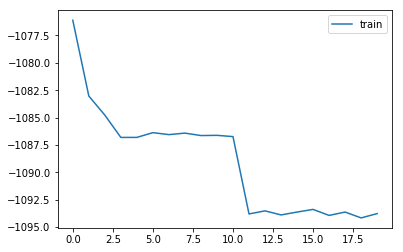

In [243]:
for epoch in range(epochs):
    ls_tr = 0.
    logloss_tr = 0.
    for batch in iterate_minibatches(X, batch_size):
        ls_tr += v_train_fn(batch)
        logloss_tr += v_logloss_fn(batch)
        
    v_losses_train.append(ls_tr/ batch_size)
    v_logloss.append(logloss_tr / batch_size)
    #for batch in iterate_minibatches(X_val, val_batches):
    #    ls_val += v_test_loss_fn(batch)
    #v_losses_valid.append(ls_val/ val_batches)
    
    if epoch%2==1:
        display.clear_output(wait=True)
        plt.plot(v_losses_train, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()

In [244]:
v_mse_fn(X[:3])

array(0.6302083333333334)

In [256]:
from sklearn.metrics import log_loss

In [257]:
log_loss(v_test_fn(X[:1]).reshape((32, 4))[0], X[0].reshape(32, 4)[0])

ValueError: Unknown label type: (array([ 0.79150165,  0.94889617,  0.77932157,  0.1585831 ]),)

In [263]:
lasagne.objectives.categorical_crossentropy(v_test_fn(X[:1]).reshape(32, 4)[:3], X[0].reshape(32, 4)[:3]).eval()

array([ 1.84147651,  0.36815454,  0.40328465])

In [267]:
lasagne.objectives.squared_error(v_test_fn(X[:5]), X[:5]).mean().eval()

array(0.3973231572842123)

In [249]:
v_test_fn(X[:1]).reshape((32, 4))

array([[ 0.79150165,  0.94889617,  0.77932157,  0.1585831 ],
       [ 0.62560771,  0.68177016,  0.24590253,  0.69201023],
       [ 0.87783899,  0.67340546,  0.3822017 ,  0.66812189],
       [ 0.57655655,  0.52857754,  0.9421131 ,  0.69663213],
       [ 0.76048553,  0.69056349,  0.25709875,  0.95489181],
       [ 0.75525989,  0.49188635,  0.09332282,  0.61285487],
       [ 0.92465327,  0.27659985,  0.59180648,  0.86809633],
       [ 0.72870477,  0.84145887,  0.66972009,  0.6714854 ],
       [ 0.80634387,  0.7146857 ,  0.75609822,  0.57015121],
       [ 0.77456462,  0.84501698,  0.68451992,  0.59106949],
       [ 0.51134624,  0.83940518,  0.3515506 ,  0.87842925],
       [ 0.77617273,  0.85783213,  0.77017629,  0.63349783],
       [ 0.69155801,  0.88569193,  0.79392248,  0.84186756],
       [ 0.80603481,  0.83032383,  0.72306777,  0.21678904],
       [ 0.82165329,  0.46041507,  0.61964982,  0.84771152],
       [ 0.67539473,  0.91451246,  0.15134564,  0.86091863],
       [ 0.15735963,  0.

In [251]:
X[0].reshape(32, 4)

array([[ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.]])

In [227]:
internal = theano.function([input_X], mu_z)

Z = internal(X)
Z_ans = internal(X_ans)

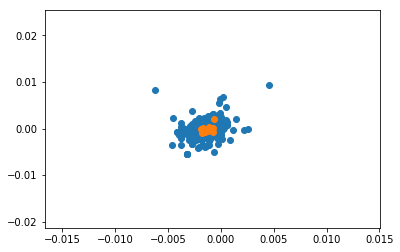

In [228]:
plt.scatter(Z[::50, 0], Z[::50,1])
plt.scatter(Z_ans[:, 0]  , Z_ans[:,1])
plt.show()

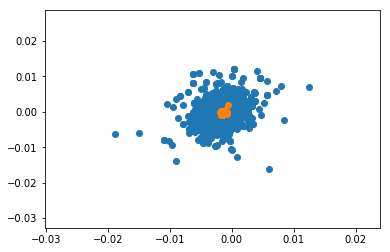

In [229]:
plt.scatter(Z[::, 0], Z[::,1])
plt.scatter(Z_ans[:, 0]  , Z_ans[:,1])
plt.show()

In [190]:
upscale.get_output_shape_for((10, 4, 31))

(10, 4, 248)

In [192]:
vl_upconv_1.get_output_shape_for((10,4,248))

(10, 1, 128)

In [ ]:
lasagne.layers.TransposedConv2DLayer()

In [103]:
test_inp_X = T.tensor3()
test_inp = lasagne.layers.InputLayer((2,1, 3))
pscale = lasagne.layers.Upscale1DLayer(test_inp, 4)

In [104]:
pscale.get_output_shape_for((2,1,3))

(2, 1, 12)

In [106]:
test_out = lasagne.layers.get_output(pscale, test_inp_X)

In [107]:
test_upsc = theano.function([test_inp_X], test_out)

In [113]:
test_upsc(test_X)

array([[[ 1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.]],

       [[ 4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  6.]]])

In [111]:
test_X = np.array([[[1, 2, 3]], [[4,5,6]]])


In [ ]:
#vl_upconv_2 = lasagne.layers.Conv1DLayer(vl_dec_hid_rs, 4, 4, pad = 3)
vl_upconv_1 = lasagne.layers.Conv1DLayer(vl_dec_hid_rs, 1, 4, pad = 3)

In [65]:
input_X = T.matrix("X")
input_shape = [None,32*4]

In [93]:
HU_encoder = 20
dimZ = 2
HU_decoder = 20

In [94]:
vl_input = lasagne.layers.InputLayer(input_shape)

vl_reshape_there = lasagne.layers.ReshapeLayer(vl_input, (-1, 1, 32*4))

vl_conv_1 = lasagne.layers.Conv1DLayer(vl_reshape_there, 4, 4)
vl_conv_2 = lasagne.layers.Conv1DLayer(vl_conv_1, 8, 4)

vl_enc_hid = lasagne.layers.DenseLayer(vl_conv_2, num_units=HU_encoder, nonlinearity = lasagne.nonlinearities.elu)

In [95]:
vl_enc_mu = lasagne.layers.DenseLayer(vl_enc_hid, dimZ, nonlinearity = None)
vl_enc_logsigma = lasagne.layers.DenseLayer(vl_enc_hid, num_units=dimZ, nonlinearity = None)

vl_z = GaussianSampleLayer(vl_enc_mu, vl_enc_logsigma)

vl_dec_to_hid = lasagne.layers.DenseLayer(vl_z, num_units=HU_decoder, nonlinearity = lasagne.nonlinearities.elu)

In [96]:
vl_dec_hid = lasagne.layers.DenseLayer(vl_dec_to_hid, num_units=8 * 122, nonlinearity = lasagne.nonlinearities.elu)
vl_dec_hid_rs = lasagne.layers.ReshapeLayer(vl_dec_hid, (-1, 8, 122))

vl_upconv_2 = lasagne.layers.Conv1DLayer(vl_dec_hid_rs, 4, 4, pad = 3)
vl_upconv_1 = lasagne.layers.Conv1DLayer(vl_upconv_2, 1, 4, pad = 3)

vl_reshape_back = lasagne.layers.ReshapeLayer(vl_upconv_1, (-1, 32*4))

In [97]:
vl_dec_mu = lasagne.layers.DenseLayer(vl_reshape_back, num_units=input_shape[1],
                                      nonlinearity = lasagne.nonlinearities.sigmoid)
relu_shift = 2
vl_dec_logsigma = lasagne.layers.DenseLayer(vl_reshape_back, num_units=input_shape[1],
                    nonlinearity = lambda a: T.nnet.relu(a+relu_shift)-relu_shift)
vl_output = GaussianSampleLayer(vl_dec_mu, vl_dec_logsigma)

In [98]:
# create prediction variable
v_prediction = lasagne.layers.get_output(vl_output, inputs = input_X, deterministic=True)
# create loss function
mu_z = lasagne.layers.get_output(vl_enc_mu, inputs= input_X)
logsigma_z = lasagne.layers.get_output(vl_enc_logsigma, inputs= input_X)
mu_x = lasagne.layers.get_output(vl_dec_mu, inputs= input_X)
logsigma_x = lasagne.layers.get_output(vl_dec_logsigma,inputs= input_X)
v_loss = -1*(KL_divergence(mu_z,logsigma_z) + log_likelihood(input_X, mu_x, logsigma_x))


# create parameter update expressions
v_params = lasagne.layers.get_all_params(vl_output, trainable = True)
v_updates = lasagne.updates.adam(v_loss, v_params, learning_rate=0.001)

# compile training and testing functions
v_train_fn = theano.function([input_X], v_loss, updates = v_updates)
v_test_fn = theano.function([input_X], v_prediction)
v_test_loss_fn = theano.function([input_X], v_loss)

In [99]:
epochs = 30
v_losses_train = []
#v_losses_valid = []
#val_batches = 500
batch_size = 100

In [102]:
for epoch in range(epochs):
    ls_tr = 0.
    ls_val = 0.
    for batch in iterate_minibatches(X_es_1[::100], batch_size):
        ls_tr += v_train_fn(batch)
    v_losses_train.append(ls_tr/ batch_size)
    #for batch in iterate_minibatches(X_val, val_batches):
    #    ls_val += v_test_loss_fn(batch)
    #v_losses_valid.append(ls_val/ val_batches)
    
    if epoch%1==1:
        display.clear_output(wait=True)
        plt.plot(v_losses_train, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()

In [112]:
K_1 = ['CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC', 'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG', 
       'GTAGTCCATCATTCCACCTATGTCTGAACTCC', 'CCGGGGGATAATGTTTACGGTCATGCGCCCCC', 
       'TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG', 'AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC',
       'TAGTTTCCGTATCTCCGGATTTATAAAGCTGA', 'GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG', 
       'GCGACCGCTCAGAAATTCCAGACCCGATCCAAA','TCAACATTATCAATTACAACCGACAGGGAGCC', 
       'AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG', 'TGCGTGAGCGTATCGCCGCGCGTCTGCGAAAG']
       
K_2 = ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC', 'CTGTTTTCGCAAATCTATGGACTATTGCTATT', 
       'GGGCGCACGGAATACAAAGCCGTGTATCTGCT', 'TGGCTCTGCAACAGCAGCACCCATGACCACGT', 
       'GAAATGCTGGTGAGCGTTAATGCCGCAAACAC', 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC']

In [113]:
X_ans = to_array([x[:32] for x in (K_1 + K_2)])

18it [00:00, 29433.71it/s]


In [105]:
internal = theano.function([input_X], mu_z)

In [115]:
Z = internal(X_es_3)
Z_ans = internal(X_ans)

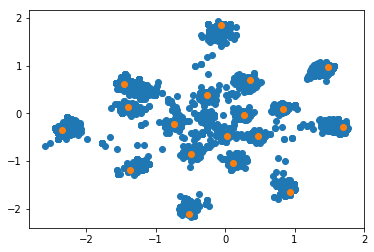

In [116]:
plt.scatter(Z[:, 0], Z[:,1])
plt.scatter(Z_ans[:, 0]  , Z_ans[:,1])
plt.show()